In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import jsonlines
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
from transformers import AdamW, AutoConfig
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.manifold import TSNE
from sklearn.svm import SVC

---
Загружаем данные

In [2]:
train_data = pd.read_json("train.jsonl", lines=True, orient="records")
val_data = pd.read_json("val.jsonl", lines=True, orient="records")
test_data = pd.read_json("test.jsonl", lines=True, orient="records")

train_data['label'] = train_data['label'].apply(lambda x: 1 if x == 'entailment' else 0)
val_data['label'] = val_data['label'].apply(lambda x: 1 if x == 'entailment' else 0)

In [3]:
train_data.head()

,premise,hypothesis,label,idx
0,"Женщину доставили в больницу, за ее жизнь сейч...",Женщину спасают врачи.,1,0
1,Он проводит невидимую грань между настоящим и ...,В эти минуты все мы подводим друг друга.,0,1
2,"Мужчина рассказал: детская коляска, принадлежа...",Сосед часто крадет детские коляски ради денег.,0,2
3,"Я просто об этом даже не думаю, потому что есл...",Спрятаться не удастся.,1,3
4,В ходе проверки нашли дома с наледью и сосульк...,Все сосульки с крыш были сбиты.,0,4


In [4]:
print('max length of train premise is: %d' % np.max([len(s) for s in train_data.premise]))
print('max length of val premise is: %d' % np.max([len(s) for s in val_data.premise]))
print('max length of test premise is: %d' % np.max([len(s) for s in test_data.premise]))

print('max length of train hypothesis is: %d' % np.max([len(s) for s in train_data.hypothesis]))
print('max length of val hypothesis is: %d' % np.max([len(s) for s in val_data.hypothesis]))
print('max length of test hypothesis is: %d' % np.max([len(s) for s in test_data.hypothesis]))

max length of train premise is: 945
max length of val premise is: 717
max length of test premise is: 945
max length of train hypothesis is: 179
max length of val hypothesis is: 129
max length of test hypothesis is: 144


In [5]:
max_len_premise = 161
max_len_hypothesis = 30

---
##### Part 0. Get embeddings

In [49]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

config = AutoConfig.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
config.output_hidden_states = True
config.return_dict = True

bmodel = AutoModelForMaskedLM.from_pretrained("DeepPavlov/rubert-base-cased-sentence", config=config)
bmodel.eval()
_ = bmodel.to('cuda')

Some weights of BertForMaskedLM were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def get_embeds(data):
    result = []
    for tokens in tqdm(data):
        cnt_tokens = len(tokens)
        embeds = bmodel(**tokenizer(tokens, return_tensors='pt', padding=True).to('cuda'))
        embeds = embeds.hidden_states[-1][0][0].cpu().detach().numpy()
        result.append(embeds)
    result = np.asarray(result)
    return result

In [53]:
train_premise = get_embeds(train_data.premise)
train_hypothesis = get_embeds(train_data.hypothesis)
train_X = np.concatenate((train_premise, train_hypothesis), axis=1)
train_y = np.array(train_data['label'])

In [55]:
val_premise = get_embeds(val_data.premise)
val_hypothesis = get_embeds(val_data.hypothesis)
val_X = np.concatenate((val_premise, val_hypothesis), axis=1)
val_y = np.array(val_data['label'])

In [56]:
test_premise = get_embeds(test_data.premise)
test_hypothesis = get_embeds(test_data.hypothesis)
test_X = np.hstack((test_premise, test_hypothesis))

---
##### Part 1. Explore your data

Сначала преобразуем эмбеддинги отдельно для premise и hypothesis и ппосмотрим на результат.

In [57]:
%time
tsne = TSNE(n_components=2, random_state=0)
vec_rep = tsne.fit_transform(np.vstack((train_X[:, :768], train_X[:, 768:])))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


[]

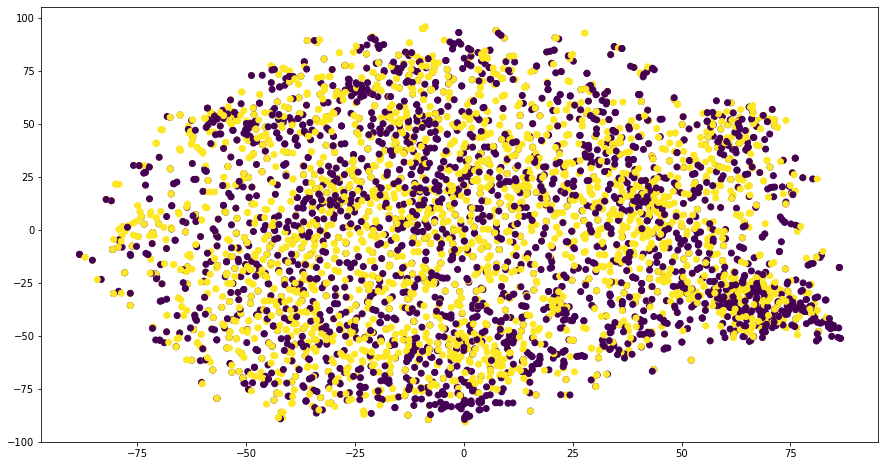

In [58]:
plt.figure(figsize=(15, 8))
plt.scatter(vec_rep[:, 0], vec_rep[:, 1], c=np.hstack((train_y, train_y)))
plt.plot()

Темный цвет -- метки, соответствующие label = 0 -- not entailment.

Светлый цвет -- метки, соответствующие label = 1 -- entailment.

Все перемешано, какие-либо выводы сделать сложно.

---
Теперь посмотрим на распределение предложений premise и hypothesis.

[]

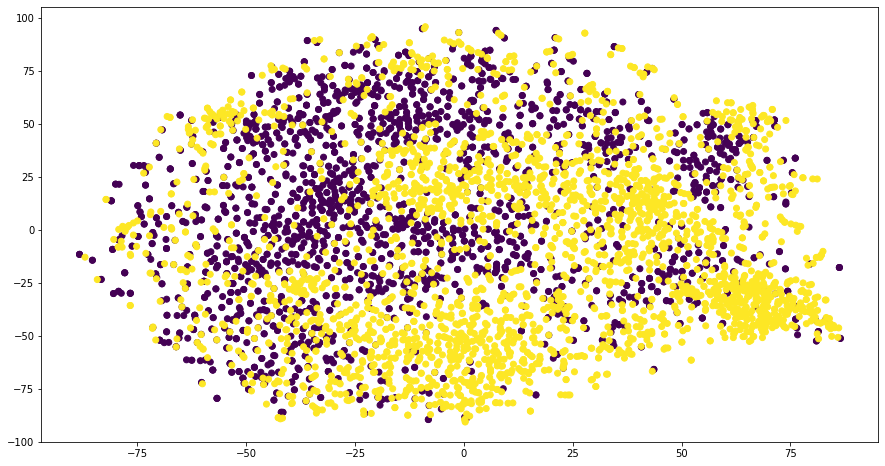

In [59]:
plt.figure(figsize=(15, 8))
plt.scatter(vec_rep[:, 0], vec_rep[:, 1], c=np.hstack((np.zeros(train_y.shape[0]), np.ones(train_y.shape[0]))))
plt.plot()

Темный цвет -- предложения premise.

Светлый цвет -- предложения hypothesis.

Видно, что предложения имеют разные распределения.

---
Теперь попробуем перевести эмбеддинги в 2d пространство, в котором координата x -- 1d представление premise, y -- 1d представление hypothesis, полученные с помощью t-sne.

In [60]:
%time
tsne = TSNE(n_components=1, random_state=0)
vec_rep = tsne.fit_transform(np.vstack((train_X[:, :768], train_X[:, 768:])))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


In [61]:
vec_rep = vec_rep.reshape(-1)

[]

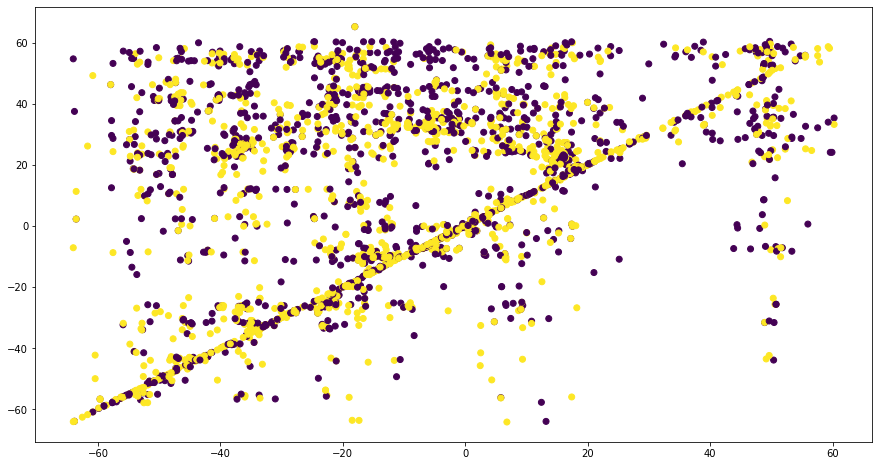

In [62]:
plt.figure(figsize=(15, 8))
plt.scatter(vec_rep[:train_X.shape[0]], vec_rep[train_X.shape[0]:], c=train_y)
plt.plot()

Темный цвет -- not entailment.

Светлый цвет -- entailment.

Большое количество точек расопложились по диагонали. У большей части меток на диагонали label=entailment, но не у всех.

##### Part 2. Make first classifier
---
LogisticRegression

In [46]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(train_X, train_y)

/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
pred = clf.predict(val_X)

In [54]:
accuracy_score(val_y, pred)

0.46905537459283386

---
SVM

In [46]:
clf = SVC(gamma='auto')

params_space = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

scorer = make_scorer(accuracy_score)

rs = RandomizedSearchCV(clf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=scorer)

In [33]:
rs.fit(train_X, train_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   43.1s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto', kernel='rbf',
                                 max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(accuracy_score), verbose=1)

In [34]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)

best params: {'kernel': 'sigmoid'}
best CV score: 0.5948012232415902


In [63]:
clf = SVC(gamma='auto', kernel='sigmoid')
clf.fit(train_X, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
pred = clf.predict(val_X)

In [65]:
accuracy_score(val_y, pred)

0.5798045602605864

---
make submit

In [19]:
def make_submit(pred, path):
    pred_names = ['not_entailment' if p == 0 else 'entailment' for p in pred]
    submission = pd.DataFrame({'Id': np.arange(len(pred)), 'Category': pred_names})
    submission.to_csv(path + '.csv', index=False)

In [40]:
pred = clf.predict(test_X)
make_submit(pred, 'dp_rubert_freezed_svm')

---

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

In [85]:
pred = cosine_similarity(val_X[:, :768], val_X[:, 768:]).diagonal() > 0.6

In [86]:
pred = np.array(pred, dtype=np.int32)

In [87]:
accuracy_score(pred, val_y)

0.5602605863192183

In [88]:
pred = cosine_similarity(test_X[:, :768], test_X[:, 768:]).diagonal() > 0.6
make_submit(pred, 'dp_rubert_freezed_cosine_sim')

---
Лучший результат показал SVM.

---
##### Part 4. Finetune LM

Сначала подготовим данные для тренировки

In [28]:
with open('LM_finetune_train_data.txt', 'a') as file:
    for s in train_data['premise']:
        file.write(s)
        
    for s in train_data['hypothesis']:
        file.write(s)
        
with open('LM_finetune_val_data.txt', 'a') as file:
    for s in val_data['premise']:
        file.write(s)
        
    for s in val_data['hypothesis']:
        file.write(s)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

config = AutoConfig.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
config.output_hidden_states = True
config.return_dict = True

bmodel = AutoModelForMaskedLM.from_pretrained("DeepPavlov/rubert-base-cased-sentence", config=config)

Some weights of BertForMaskedLM were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
train_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="./LM_finetune_train_data.txt",
    block_size=512,
)

val_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="./LM_finetune_val_data.txt",
    block_size=512,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir="./rubert-retrained",
    overwrite_output_dir=True,
    num_train_epochs=100,
    evaluation_strategy="steps",
    logging_steps=10,
    eval_steps=10,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    seed=1
)

/home/coder/anaconda3/lib/python3.7/site-packages/transformers/data/datasets/language_modeling.py:114: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_mlm.py
  FutureWarning,


In [8]:
trainer = Trainer(
    model=bmodel,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Step,Training Loss,Validation Loss
10,9.258693,8.574541
20,8.009810,8.643877
30,7.550630,8.671666
40,6.968367,7.651812
50,6.258148,8.194244
60,5.719699,6.944844
70,5.591226,7.927718
80,5.138397,7.560308
90,5.004944,8.072528
100,5.025671,7.503569


TrainOutput(global_step=100, training_loss=6.45255859375)

In [11]:
bmodel.eval()
_ = bmodel.to('cuda')

train_premise = get_embeds(train_data.premise)
train_hypothesis = get_embeds(train_data.hypothesis)
train_X = np.concatenate((train_premise, train_hypothesis), axis=1)
train_y = np.array(train_data['label'])

val_premise = get_embeds(val_data.premise)
val_hypothesis = get_embeds(val_data.hypothesis)
val_X = np.concatenate((val_premise, val_hypothesis), axis=1)
val_y = np.array(val_data['label'])

test_premise = get_embeds(test_data.premise)
test_hypothesis = get_embeds(test_data.hypothesis)
test_X = np.hstack((test_premise, test_hypothesis))

In [12]:
clf = SVC(gamma='auto')

params_space = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

scorer = make_scorer(accuracy_score)

rs = RandomizedSearchCV(clf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=scorer)

rs.fit(train_X, train_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   32.1s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto', kernel='rbf',
                                 max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(accuracy_score), verbose=1)

In [13]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)

best params: {'kernel': 'rbf'}
best CV score: 0.5913608562691132


In [12]:
clf = SVC(gamma='auto', kernel='sigmoid')
clf.fit(train_X, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
pred = clf.predict(val_X)
accuracy_score(pred, val_y)

0.5895765472312704

In [20]:
pred = clf.predict(test_X)
make_submit(pred, 'dp_rubert_finetuned_svm')

---
##### Part 3. Finetune on Classification task

In [12]:
train_X = np.array(list(zip(list(train_data.premise), list(train_data.hypothesis))))
train_y = np.array(train_data['label'])

val_X = np.array(list(zip(list(val_data.premise), list(val_data.hypothesis))))
val_y = np.array(val_data['label'])

test_X = np.array(list(zip(list(test_data.premise), list(test_data.hypothesis))))

In [6]:
BATCH_SIZE = 8
EPOCHS = 20
DEVICE = torch.device('cuda')

In [7]:
def iterate_minibatches(data, batch_size=256, shuffle=True):
    """ iterates minibatches of data in random order """
    indices = np.arange(len(data[0]))
    if shuffle:
        indices = np.random.permutation(indices)

    for start in range(0, len(indices), batch_size):
        batch = [data[0][indices[start : start + batch_size]], data[1][indices[start : start + batch_size]]]
        yield batch

In [8]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cuda')):
    loss = accuracy = num_samples = 0.0
    model.bmodel.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False):
            pred = model(batch)
            y = torch.tensor(batch[1], dtype=torch.long, device=DEVICE)
            loss += criterion(pred.float(), y)
            accuracy += torch.mean((torch.argmax(pred, axis=-1).float() == y.float()).float())
            num_samples += 1
            
    loss = loss.detach().cpu().numpy() / num_samples
    accuracy = accuracy / num_samples
    print("%s val results:" % (name or ""))
    print("loss: %.5f" % loss)
    print("accuracy: %.5f" % accuracy.detach().cpu().numpy())
    return loss, accuracy

In [21]:
class NNclf(nn.Module):
    def __init__(self, emb_dim=768, device=torch.device('cuda')):
        super().__init__()
        
        self.device = device
        
        self.tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

        config = AutoConfig.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
        config.output_hidden_states = True
        config.return_dict = True

        self.bmodel = AutoModelForMaskedLM.from_pretrained("DeepPavlov/rubert-base-cased-sentence", config=config)
        _ = self.bmodel.to('cuda')
        
        for param in self.bmodel.base_model.parameters():
            param.requires_grad = False
        
        self.linear = nn.Linear(emb_dim, emb_dim)
        self.transformation = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.Tanh()
        )
        
        self.dropout = torch.nn.Dropout(0.3)
        
        self.final_predictor = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 2)
        )
        
    def forward(self, batch):
        premise = list(batch[0][:, 0])
        hypothesis = list(batch[0][:, 1])
        
        embeds_premise = self.bmodel(**self.tokenizer(premise, return_tensors='pt', padding=True).to('cuda'))
        embeds_premise = embeds_premise.hidden_states[-1][:, 0]
        
        embeds_hypothesis = self.bmodel(**self.tokenizer(hypothesis, return_tensors='pt', padding=True).to('cuda'))
        embeds_hypothesis = embeds_hypothesis.hidden_states[-1][:, 0]
        
        embeds = self.dropout(self.transformation(embeds_premise) * self.transformation(embeds_hypothesis))
        
        return self.final_predictor(embeds)
    
    def predict(self, data):
        answer = []
        for item in data:
            pred = torch.argmax(self.forward(np.array([[item]])))
            answer.append(pred.detach().cpu().numpy())
        return answer

In [39]:
model = NNclf(device=DEVICE).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

for epoch in tqdm(range(EPOCHS)):
    
    model.bmodel.train()
    epoch_loss = 0
    epoch_accuracy = 0
    iterations = 0
    for i, batch in tqdm(enumerate(iterate_minibatches([train_X, train_y], batch_size=BATCH_SIZE))):
        pred = model(batch)
        y = torch.tensor(batch[1], dtype=torch.long, device=DEVICE)
        loss = criterion(pred, y)
        accuracy = torch.mean((torch.argmax(pred, axis=-1).float() == y.float()).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        epoch_accuracy += accuracy
        iterations += 1
    
#     if epoch % 10 == 0:
    print(f"epoch: {epoch}")
    print("train results:")
    print("loss: ", epoch_loss.detach().cpu().numpy() / iterations)
    print("accuracy:", epoch_accuracy.detach().cpu().numpy() / iterations)    
    print_metrics(model, [val_X, val_y])

Some weights of BertForMaskedLM were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 0
train results:
loss:  0.6911238924078985
accuracy: 0.5282874617737003
 val results:
loss: 0.68744
accuracy: 0.56197



epoch: 1
train results:
loss:  0.6838628553104692
accuracy: 0.5695718654434251
 val results:
loss: 0.67868
accuracy: 0.57372



epoch: 2
train results:
loss:  0.6773707771884556
accuracy: 0.5730122324159022
 val results:
loss: 0.67424
accuracy: 0.58761



epoch: 3
train results:
loss:  0.6709074434519543
accuracy: 0.5970948012232415
 val results:
loss: 0.66965
accuracy: 0.60256



epoch: 4
train results:
loss:  0.6663613508965262
accuracy: 0.6047400611620795
 val results:
loss: 0.66198
accuracy: 0.57051



epoch: 5
train results:
loss:  0.6601080471587109
accuracy: 0.6127675840978594
 val results:
loss: 0.66242
accuracy: 0.59936



epoch: 6
train results:
loss:  0.6573900695240825
accuracy: 0.6162079510703364
 val results:
loss: 0.66147
accuracy: 0.58654



epoch: 7
train results:
loss:  0.6532316062063981
accuracy: 0.6204128440366973
 val results:
loss: 0.66558
accuracy: 0.58761



epoch: 8
train results:
loss:  0.649837902197415
accuracy: 0.6169724770642202
 val results:
loss: 0.67002
accuracy: 0.57692



epoch: 9
train results:
loss:  0.6467100370914565
accuracy: 0.6242354740061162
 val results:
loss: 0.66511
accuracy: 0.58761


KeyboardInterrupt: 

In [55]:
predicted_classes = model.predict(test_X)

make_submit(predicted_classes, 'dp_rubert_finetuned_nnclassifier')

---
##### Part 5. Finetune on classification task your new LM model

In [9]:
class NNclf(nn.Module):
    def __init__(self, emb_dim=768, device=torch.device('cuda')):
        super().__init__()
        
        self.device = device
        
        self.tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

        config = AutoConfig.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
        config.output_hidden_states = True
        config.return_dict = True

        self.bmodel = AutoModelForMaskedLM.from_pretrained("DeepPavlov/rubert-base-cased-sentence", config=config)

        train_dataset = LineByLineTextDataset(
            tokenizer=self.tokenizer,
            file_path="./LM_finetune_train_data.txt",
            block_size=512,
        )

        val_dataset = LineByLineTextDataset(
            tokenizer=self.tokenizer,
            file_path="./LM_finetune_val_data.txt",
            block_size=512,
        )

        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer, mlm=True, mlm_probability=0.15
        )

        training_args = TrainingArguments(
            output_dir="./rubert-retrained",
            overwrite_output_dir=True,
            num_train_epochs=100,
            evaluation_strategy="steps",
            logging_steps=10,
            eval_steps=10,
            per_device_train_batch_size=8,
            save_steps=500,
            save_total_limit=1,
            seed=1
        )
        
        trainer = Trainer(
            model=self.bmodel,
            args=training_args,
            data_collator=data_collator,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        trainer.train()
        
        _ = self.bmodel.to('cuda')
        
        for param in self.bmodel.base_model.parameters():
            param.requires_grad = False
        
        self.linear = nn.Linear(emb_dim, emb_dim)
        self.transformation = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.Tanh()
        )
        
        self.dropout = torch.nn.Dropout(0.3)
        
        self.final_predictor = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 2)
        )
        
    def forward(self, batch):
        premise = list(batch[0][:, 0])
        hypothesis = list(batch[0][:, 1])
        
        embeds_premise = self.bmodel(**self.tokenizer(premise, return_tensors='pt', padding=True).to('cuda'))
        embeds_premise = embeds_premise.hidden_states[-1][:, 0]
        
        embeds_hypothesis = self.bmodel(**self.tokenizer(hypothesis, return_tensors='pt', padding=True).to('cuda'))
        embeds_hypothesis = embeds_hypothesis.hidden_states[-1][:, 0]
        
        embeds = self.dropout(self.transformation(embeds_premise) * self.transformation(embeds_hypothesis))
        
        return self.final_predictor(embeds)
    
    def predict(self, data):
        answer = []
        for item in data:
            pred = torch.argmax(self.forward(np.array([[item]])))
            answer.append(pred.detach().cpu().numpy())
        return answer

In [10]:
model = NNclf(device=DEVICE).to(DEVICE)

Some weights of BertForMaskedLM were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/coder/anaconda3/lib/python3.7/site-packages/transformers/data/datasets/language_modeling.py:114: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_mlm.py
  FutureWarning,


Step,Training Loss,Validation Loss
10,9.371620,8.632857
20,8.045604,8.706366
30,7.729205,8.805407
40,7.397574,8.007306
50,6.866422,8.449406
60,6.359518,7.439457
70,6.193008,8.048609
80,5.747174,7.770627
90,5.631024,8.228033
100,5.541962,7.671929


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

for epoch in tqdm(range(EPOCHS)):
    
    model.bmodel.train()
    epoch_loss = 0
    epoch_accuracy = 0
    iterations = 0
    for i, batch in tqdm(enumerate(iterate_minibatches([train_X, train_y], batch_size=BATCH_SIZE))):
        pred = model(batch)
        y = torch.tensor(batch[1], dtype=torch.long, device=DEVICE)
        loss = criterion(pred, y)
        accuracy = torch.mean((torch.argmax(pred, axis=-1).float() == y.float()).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        epoch_accuracy += accuracy
        iterations += 1
    
#     if epoch % 10 == 0:
    print(f"epoch: {epoch}")
    print("train results:")
    print("loss: ", epoch_loss.detach().cpu().numpy() / iterations)
    print("accuracy:", epoch_accuracy.detach().cpu().numpy() / iterations)    
    print_metrics(model, [val_X, val_y])


epoch: 0
train results:
loss:  0.6915116616345327
accuracy: 0.5248470948012233
 val results:
loss: 0.68683
accuracy: 0.56517



epoch: 1
train results:
loss:  0.6847769361023509
accuracy: 0.5657492354740061
 val results:
loss: 0.67720
accuracy: 0.57158



epoch: 2
train results:
loss:  0.6802102185170585
accuracy: 0.5726299694189603
 val results:
loss: 0.67588
accuracy: 0.56517



epoch: 3
train results:
loss:  0.67766265402511
accuracy: 0.5764525993883792
 val results:
loss: 0.67345
accuracy: 0.57479



epoch: 4
train results:
loss:  0.6717612823579654
accuracy: 0.5902140672782875
 val results:
loss: 0.67601
accuracy: 0.56517



epoch: 5
train results:
loss:  0.6680203592376243
accuracy: 0.6047400611620795
 val results:
loss: 0.66967
accuracy: 0.57158



epoch: 6
train results:
loss:  0.66405475394806
accuracy: 0.6116207951070336
 val results:
loss: 0.66854
accuracy: 0.56838



epoch: 7
train results:
loss:  0.6612681817570958
accuracy: 0.6097094801223242
 val results:
loss: 0.66635
accuracy: 0.57692



epoch: 8
train results:
loss:  0.657969856845494
accuracy: 0.6081804281345565
 val results:
loss: 0.67259
accuracy: 0.56090



epoch: 9
train results:
loss:  0.6544524493202886
accuracy: 0.6169724770642202
 val results:
loss: 0.67101
accuracy: 0.55235


KeyboardInterrupt: 

---
##### Part 6. Results

|№| метод         | accuracy      |
|----------| ------------- |:-------------:|
|Part 2.| SVM classifier | 0.638 |
|Part 3.| finetuned LM head + NN classifier | 0.611 |
|Part 4.| finetuned LM + SVM classifier | 0.600 |
|Part 5.| finetuned LM + finetuned LM head + NN classifier | ? |
